<a href="https://colab.research.google.com/github/monta0315/bokete/blob/main/bokete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Mon Aug 15 10:27:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

     |████████████████████████████████| 4.0 MB 31.9 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 880 kB 58.7 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 6.6 MB 56.5 MB/s 
     |████████████████████████████████| 1.3 MB 34.0 MB/s 
     |████████████████████████████████| 4.1 MB 33.9 MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import japanize_matplotlib

import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [22]:
#画像データのzipを解凍します
!unzip /content/drive/MyDrive/Bokete/train.zip -d /content/train
#!unzip /content/drive/MyDrive/Bokete/test.zip -d /content/test

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/train/luopfmyekz.jpg  
  inflating: /content/train/ob55phj29m.jpg  
  inflating: /content/train/dwtwh41cea.jpg  
  inflating: /content/train/7irelycwlh.jpg  
  inflating: /content/train/eua7wnl5ck.jpg  
  inflating: /content/train/rzq6khkrfy.jpg  
  inflating: /content/train/tpamwhhntb.jpg  
  inflating: /content/train/jpp1oygbbg.jpg  
  inflating: /content/train/vk39c3qt9m.jpg  
  inflating: /content/train/0wxaxgmlg0.jpg  
  inflating: /content/train/wm6a2omeaj.jpg  
  inflating: /content/train/pvybxvbp86.jpg  
  inflating: /content/train/gkgoonxdts.jpg  
  inflating: /content/train/ldsk6fou68.jpg  
  inflating: /content/train/ulrosqejxx.jpg  
  inflating: /content/train/c2gwhe8i5l.jpg  
  inflating: /content/train/qv9h8hb6mg.jpg  
  inflating: /content/train/dpvght4u6z.jpg  
  inflating: /content/train/yqjryg6qba.jpg  
  inflating: /content/train/zjackofx20.jpg  
  inflating: /content/train/8oqm4jdumg.jpg  
  inflating: /content/t

# Read Data
学習データと推論データについて、目的変数の分布などを確認していきます。

In [8]:
INPUT = "/content/drive/MyDrive/Bokete" # 所望のディレクトリに変更してください。
train_image_path = "/content/train/"
test_image_path = "/content/test/"

In [9]:
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [10]:
print(f"train_data: {train_df.shape}")
display(train_df.head())

print(f"test_data: {test_df.shape}")
display(test_df.head())

train_data: (24962, 4)


,id,odai_photo_file_name,text,is_laugh
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0


test_data: (6000, 3)


,id,odai_photo_file_name,text
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...


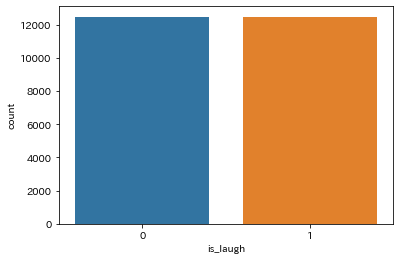

In [11]:
# 目的変数の分布を確認する
sns.countplot(x="is_laugh", data=train_df)

In [12]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

In [13]:
# 画像の重複があるか確認する
print(train_df["odai_photo_file_name"].duplicated().sum())
print(test_df["odai_photo_file_name"].duplicated().sum())

0
0


In [14]:
train_df.columns

Index(['id', 'odai_photo_file_name', 'text', 'is_laugh'], dtype='object')

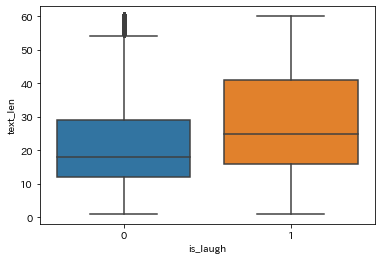

In [15]:
# 文書の長さとflagの関係を確認する
train_df["text_len"] = train_df["text"].str.len()
test_df["text_len"] = test_df["text"].str.len()

sns.boxplot(x="is_laugh", y="text_len", data=train_df)

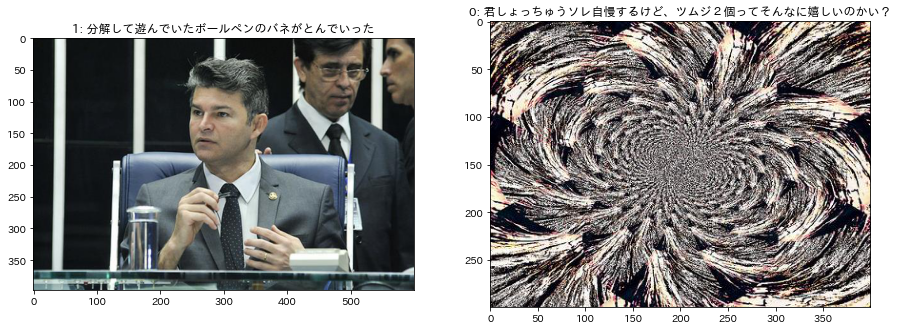

In [23]:
# データ内にあるボケてを確認してみる

fig = plt.figure(figsize=(15,7))

data1 = train_df[train_df["is_laugh"]==1]
image_path1 = train_image_path + data1.iloc[0]["odai_photo_file_name"]
img1 = img = Image.open(image_path1)

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
plt.title(str(data1.iloc[0]["is_laugh"])+ ": "+ data1.iloc[0]["text"])

data2 = train_df[train_df["is_laugh"]==0]
image_path2 = train_image_path + data2.iloc[0]["odai_photo_file_name"]
img2 = img = Image.open(image_path2)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)
plt.title(str(data2.iloc[0]["is_laugh"])+ ": "+ data2.iloc[0]["text"])

plt.show()

個人的な主観も含まれてしまいますが、以下のようなことがわかってきました。  
- ファイル名で確認すると、画像の重複はtrainとtestではない。
- ボケての文章の長さを確認すると、面白いボケての方が文章が長い傾向
- 画像とボケての文章を見てみると、確かに１と０で差がありそう（個人的に０の方はどのようにボケているのかが少しわかりにくい感じがあります）

今回は単純に文章の長さのみを確認しましたが、他にも文章自体について注目していくと、面白さに関する知見というのが見えてくるかも知れません。


# Create Image Features

ボケてというものは、画像と文章の組み合わせで面白さを表現しているので、以下にして画像のデータと文章のデータをモデルに学習させるかがポイントになってくるかと思います。

画像のデータを特徴量として用いるために、今回はDenseNet121の学習済みモデルを用います。

In [25]:
import cv2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from tqdm import tqdm, tqdm_notebook
from keras.applications.densenet import preprocess_input, DenseNet121

In [26]:
class CFG:
    img_size = 224
    batch_size = 17

In [27]:
def resize_to_square(im):
    old_size = im.shape[:2] 
    ratio = float(CFG.img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # 画像サイズを224×224に変更します
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = CFG.img_size - new_size[1]
    delta_h = CFG.img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im


def load_image(ids, is_train=True):
  if is_train:
    image = cv2.imread(train_image_path+ids)
  else:
    image = cv2.imread(test_image_path+ids)
  new_image = resize_to_square(image)
  new_image = preprocess_input(new_image)
  return new_image

In [28]:
inp = Input((224,224,3))
backbone = DenseNet121(input_tensor = inp, include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

29097984/29084464 [==============================] - 1s 0us/step


In [29]:
image_df_train = train_df[["id", "odai_photo_file_name"]].copy()
image_df_train.head()

,id,odai_photo_file_name
0,ge5kssftl,9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg


In [30]:
image_ids = image_df_train["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1

In [31]:
features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

100%|██████████| 1469/1469 [05:35<00:00,  4.38it/s]


In [32]:
image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

In [33]:
# trainのデータに結合します。
train_df = pd.merge(train_df, image_feature, on="odai_photo_file_name", how="left")

In [35]:
# CNNで特徴量を増やしている => もっと調べないといけない
train_df.shape

(24962, 261)

In [40]:
# testデータでも同様なことを行って行きます
image_df_test = test_df[["id", "odai_photo_file_name"]].copy()

image_ids = image_df_test["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1


features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id, is_train=False)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

test_df = pd.merge(test_df, image_feature, on="odai_photo_file_name", how="left")

100%|██████████| 353/353 [01:28<00:00,  3.99it/s]


In [41]:
test_df.shape

(6000, 516)

# Create Text Features

続いてボケての文章について、BERTモデルを用いて特徴量化していきます。
特徴量化については、以下のディスカッションを参考にさせていただきます。  
[japanese-roberta-baseでテキストデータをembeddingする(小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~ より)](https://www.nishika.com/competitions/21/topics/163)


In [ ]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

In [ ]:
class BertSequenceVectorizer:
    def __init__(self, model_name: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.do_lower_case = True 
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 256


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

In [42]:
BSV = BertSequenceVectorizer('rinna/japanese-roberta-base')

## テキストの欠損値を補間します
train_df["text"] = train_df["text"].fillna('NaN')
test_df["text"] = test_df["text"].fillna('NaN')

## BERT特徴量 
features_text_train = np.stack(train_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)
features_text_test = np.stack(test_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

Some weights of the model checkpoint at rinna/japanese-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to b

In [43]:
## テキスト特徴量
features_text_train_df = pd.DataFrame(features_text_train).add_prefix("Roberta-text")
features_text_test_df = pd.DataFrame(features_text_test).add_prefix("Roberta-text")

train_df = pd.concat([train_df, features_text_train_df], axis=1)
test_df = pd.concat([test_df, features_text_test_df], axis=1)

In [44]:
print(train_df.shape)
print(test_df.shape)

(24962, 1029)
(6000, 1284)


In [45]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

# Data Split

In [46]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

In [47]:
print(train_x.shape)
print(valid_x.shape)

(19969, 1025)
(4993, 1025)


In [48]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	train's binary_logloss: 0.611543	valid's binary_logloss: 0.660778
[100]	train's binary_logloss: 0.572134	valid's binary_logloss: 0.658425
[150]	train's binary_logloss: 0.541987	valid's binary_logloss: 0.658595
Early stopping, best iteration is:
[101]	train's binary_logloss: 0.571575	valid's binary_logloss: 0.658302


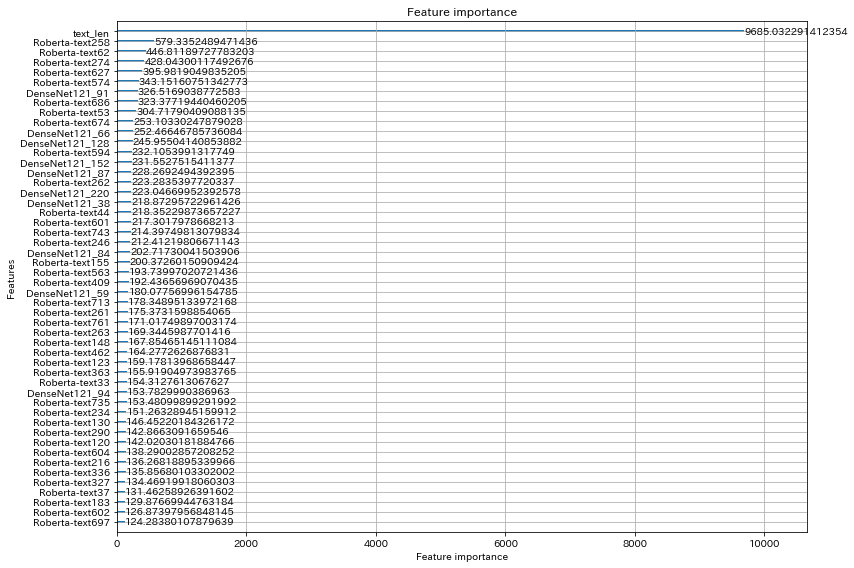

In [49]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [50]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.6146605247346285


Text(0.5, 52.0, 'Predict')

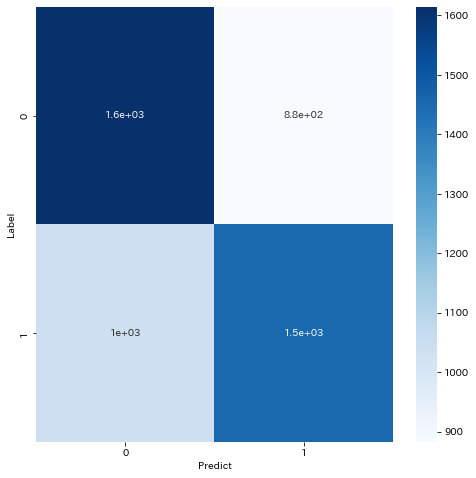

In [51]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

In [52]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [53]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.406295
1,tsgqmfpef,0.319645
2,owjcthkz2,0.353627
3,rvgaocjyy,0.473836
4,uxtwu5i69,0.696345


In [54]:
OUTPUT = "/content/drive/MyDrive/Bokete" # ディレクトリを指定してください
submission_df.to_csv(os.path.join(OUTPUT,'submission.csv'), index=False)